In [ ]:
import os
import cv2
import time
import shutil
import torch
import torchvision
from torchvision.models.detection import KeypointRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.anchor_utils import AnchorGenerator
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.distributed as dist
from google.colab import files

In [ ]:
torch.manual_seed(22);

In [ ]:
files.upload(); #animals_data.zip

In [ ]:
data_dir = '/content/data'

In [ ]:
shutil.unpack_archive('/content/animals_data.zip', data_dir)

In [ ]:
def features_to_dict(features):
    target_dict = dict()

    target_dict['boxes'] = torch.FloatTensor([[features[5], features[6], features[5] + features[7], features[6] + features[8]]])
    target_dict['labels'] = torch.IntTensor([features[:5].argmax() + 1]).long()
    keypoints_list = list()
    for i in range(9, 67, 3):
      keypoints_list.append([features[i+1], features[i+2], features[i]])

    target_dict['keypoints'] = torch.FloatTensor([keypoints_list])

    return target_dict

In [ ]:
class AnimalsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_idx = self.data.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, "0"*(3-len(str(img_idx))) + str(img_idx) + ".jpeg")
        image = Image.open(img_name)
        features = self.data.iloc[idx, 1:].to_numpy()

        if self.transform:
            image = self.transform(image)

        sample = (image, features_to_dict(features))

        return sample

In [ ]:
target_size = (256, 256)

In [ ]:
train_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))]), p=0.1),
        torchvision.transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor()
])

df = pd.read_csv(os.path.join(data_dir, 'animals_data.csv'))


for column in df.columns:
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        df[column] = df[column].astype(float)

df_dict = df.to_dict()

for idx in df_dict['id'].values():
    img_name = os.path.join(data_dir, 'animals', "0"*(3-len(str(idx))) + str(idx) + ".jpeg")
    image = Image.open(img_name)
    x_size, y_size = image.size
    for column in df_dict.keys():
        if '_x' in column or '_width' in column:
            df_dict[column][idx] *= target_size[0]
            df_dict[column][idx] //= x_size
        elif '_y' in column or '_height' in column:
            df_dict[column][idx] *= target_size[1]
            df_dict[column][idx] //= y_size

df = pd.DataFrame.from_dict(df_dict)

dataset = AnimalsDataset(csv_file=df, root_dir=os.path.join(data_dir, 'animals'), transform=train_transforms)

print(f"Экземпляров в датасете: {len(dataset)}")

Экземпляров в датасете: 967


In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [800, 167])

batch_size = 6
num_workers = 0

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone.out_channels = 1280

# backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
# backbone.out_channels = 960

backbone = torchvision.models.mobilenet_v3_small(pretrained=True).features
backbone.out_channels = 576

anchor_generator = AnchorGenerator(sizes=((16, 32, 64, 128, 256),), aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=14, sampling_ratio=2)

model = KeypointRCNN(backbone, num_classes=6, num_keypoints=20,
                     rpn_anchor_generator=anchor_generator,
                     box_roi_pool=roi_pooler, keypoint_roi_pool=keypoint_roi_pooler)

model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, amsgrad=True, lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [ ]:
def keypoints_accuracy(output, target):    
    accuracy = 0.
    if len(output['scores']) > 0:
        keypoints_out = (output['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)
        keypoints_scores = output['keypoints_scores'][0].numpy()
        keypoints_tgt = (target['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)

        num_keypoints = 0
        sum_accs = 0.
        min_score = 1
        for k in range(keypoints_tgt.shape[0]):
            if keypoints_tgt[k, 2] == 1:
                num_keypoints += 1
                if keypoints_out[k, 2] == 1 and keypoints_scores[k] > min_score:
                    sum_accs += 1 - np.sqrt(((keypoints_out[k, 0] - keypoints_tgt[k, 0])/target_size[0])**2 + ((keypoints_out[k, 1] - keypoints_tgt[k, 1])/target_size[1])**2)
        accuracy = sum_accs / num_keypoints

    return accuracy

In [ ]:
def accuracy_count(output, target):    
    acc_keypoints = 0.
    true_label = 0
    if len(output['scores']) > 0:
        if output['labels'][0].cpu() == target['labels'][0].cpu():
            true_label = 1

        keypoints_out = (output['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)
        keypoints_scores = output['keypoints_scores'][0].numpy()
        keypoints_tgt = (target['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)

        num_keypoints = 0
        sum_accs = 0.
        min_score = 1
        for k in range(keypoints_tgt.shape[0]):
            if keypoints_tgt[k, 2] == 1:
                num_keypoints += 1
                if keypoints_out[k, 2] == 1 and keypoints_scores[k] > min_score:
                    sum_accs += 1 - np.sqrt(((keypoints_out[k, 0] - keypoints_tgt[k, 0])/target_size[0])**2 + ((keypoints_out[k, 1] - keypoints_tgt[k, 1])/target_size[1])**2)
        acc_keypoints = sum_accs / num_keypoints

    return acc_keypoints, true_label

In [ ]:
num_epochs = 20

loss_history = []
acc_keypoints_history = []
acc_labels_history = []

eval_time = 0.
eval_num = 0

start_time = time.time()
for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}:'.format(epoch, num_epochs - 1))

    for phase in ['train', 'eval']:
        if phase == 'train':
            dataloader = train_dataloader
            if epoch != 0:
                scheduler.step()
            model.train()
        else:
            dataloader = val_dataloader
            model.eval()

        running_loss = 0.
        running_acc_keypoints = 0.
        running_acc_labels = 0.

        for images, targets in tqdm(dataloader):
            images = images.to(device)

            targets_list = list()
            for target_idx in range(len(targets['labels'])):
                targets_list.append(dict())
                for item in targets.items():
                    targets_list[-1][item[0]] = item[1][target_idx].to(device)
            targets = targets_list

            optimizer.zero_grad()

            if phase == 'train':
                with torch.set_grad_enabled(True):
                    loss_dict = model(images, targets)

                    losses = sum(loss for loss in loss_dict.values())
                    loss_dict_reduced = reduce_dict(loss_dict)
                    losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                    loss_value = losses_reduced.item()

                    losses.backward()
                    optimizer.step()

                running_loss += loss_value
            
            else:
                with torch.set_grad_enabled(False):
                    outputs = model(images)
                
                batch_acc_keypoints = 0.
                batch_acc_labels = 0.
                for image_idx in range(len(images)):
                    output = outputs[image_idx]
                    target = targets[image_idx]

                    for key in output.keys():
                        output[key] = output[key].cpu()
                    for key in target.keys():
                        target[key] = target[key].cpu()

                    acc_keypoints, acc_labels = accuracy_count(output, target)
                    batch_acc_keypoints += acc_keypoints
                    batch_acc_labels += acc_labels

                running_acc_keypoints += batch_acc_keypoints / len(images)
                running_acc_labels += batch_acc_labels / len(images)
        
        if phase == 'train':
            epoch_loss = running_loss / len(dataloader)
            loss_history.append(epoch_loss)

            print('   {} loss: {:.4f}'.format(phase.upper(), epoch_loss), flush=True)
        else:
            epoch_acc_keypoints = running_acc_keypoints / len(dataloader)
            acc_keypoints_history.append(epoch_acc_keypoints)

            epoch_acc_labels = running_acc_labels / len(dataloader)
            acc_labels_history.append(epoch_acc_labels)

            print('     {} keypoints acc: {:.4f}  labels acc: {:.4f}'.format(phase.upper(), epoch_acc_keypoints, epoch_acc_labels), flush=True)

end_time = time.time()
elapsed_time = end_time - start_time


Epoch 0/14:


100%|██████████| 150/150 [01:26<00:00,  1.74it/s]

   TRAIN loss: 7.2772



100%|██████████| 12/12 [00:03<00:00,  3.72it/s]

     EVAL  keypoints acc: 0.7432  labels acc: 0.5278

Epoch 1/14:



100%|██████████| 150/150 [01:26<00:00,  1.73it/s]

   TRAIN loss: 5.6657



100%|██████████| 12/12 [00:04<00:00,  2.42it/s]

     EVAL  keypoints acc: 0.7907  labels acc: 0.4583

Epoch 2/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 5.1077



100%|██████████| 12/12 [00:03<00:00,  3.22it/s]

     EVAL  keypoints acc: 0.8389  labels acc: 0.5972

Epoch 3/14:



100%|██████████| 150/150 [01:25<00:00,  1.75it/s]

   TRAIN loss: 4.5147



100%|██████████| 12/12 [00:03<00:00,  3.03it/s]

     EVAL  keypoints acc: 0.8796  labels acc: 0.5139

Epoch 4/14:



100%|██████████| 150/150 [01:24<00:00,  1.77it/s]

   TRAIN loss: 4.3072



100%|██████████| 12/12 [00:03<00:00,  3.32it/s]

     EVAL  keypoints acc: 0.8817  labels acc: 0.5833

Epoch 5/14:



100%|██████████| 150/150 [01:24<00:00,  1.77it/s]

   TRAIN loss: 4.2034



100%|██████████| 12/12 [00:03<00:00,  3.24it/s]

     EVAL  keypoints acc: 0.8856  labels acc: 0.5833

Epoch 6/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0901



100%|██████████| 12/12 [00:03<00:00,  3.21it/s]

     EVAL  keypoints acc: 0.8825  labels acc: 0.5833

Epoch 7/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0571



100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

     EVAL  keypoints acc: 0.8702  labels acc: 0.5833

Epoch 8/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0411



100%|██████████| 12/12 [00:03<00:00,  3.37it/s]

     EVAL  keypoints acc: 0.8887  labels acc: 0.5833

Epoch 9/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0284



100%|██████████| 12/12 [00:03<00:00,  3.24it/s]

     EVAL  keypoints acc: 0.8861  labels acc: 0.5833

Epoch 10/14:



100%|██████████| 150/150 [01:25<00:00,  1.75it/s]

   TRAIN loss: 4.0268



100%|██████████| 12/12 [00:03<00:00,  3.29it/s]

     EVAL  keypoints acc: 0.8859  labels acc: 0.5833

Epoch 11/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0401



100%|██████████| 12/12 [00:03<00:00,  3.34it/s]

     EVAL  keypoints acc: 0.8759  labels acc: 0.5833

Epoch 12/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0242



100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

     EVAL  keypoints acc: 0.8876  labels acc: 0.5694

Epoch 13/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0270



100%|██████████| 12/12 [00:03<00:00,  3.32it/s]

     EVAL  keypoints acc: 0.8893  labels acc: 0.5833

Epoch 14/14:



100%|██████████| 150/150 [01:25<00:00,  1.76it/s]

   TRAIN loss: 4.0330



100%|██████████| 12/12 [00:03<00:00,  3.30it/s]

     EVAL  keypoints acc: 0.8910  labels acc: 0.5833


Best loss: 4.0242


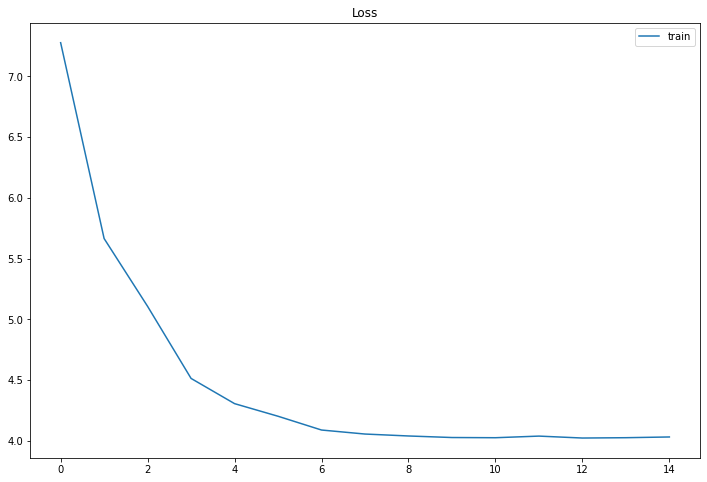


Best acc keypoints: 0.8910
Best acc labels: 0.5972


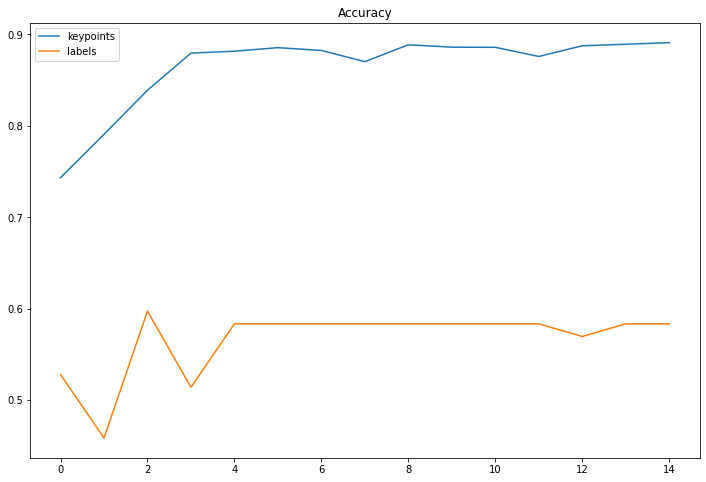


Training time: 1336


In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(loss_history, label='train')
plt.legend()
plt.title('Loss');
print('Best loss: {:.4f}'.format(min(loss_history)))
plt.show()

print()

plt.plot(acc_keypoints_history, label='keypoints')
plt.plot(acc_labels_history, label='labels')
plt.legend()
plt.title('Accuracy');
print('Best acc keypoints: {:.4f}'.format(max(acc_keypoints_history)))
print('Best acc labels: {:.4f}'.format(max(acc_labels_history)))
plt.show()

print()
print('Training time: {}'.format(int(elapsed_time)))

#   model               loss    acc     train time
#   MobileNet V2        4.5905  0.7735  2539
#   MobileNet V3 Large  3.7927  0.8953  2067
#   MobileMet V3 Small  4.0043  0.9008  1352

In [ ]:
 model.eval();

In [ ]:
files.upload(); #test_images.zip

In [ ]:
test_data_dir = '/content/data/images'

shutil.unpack_archive('/content/test_images.zip', data_dir)

In [ ]:
test_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
])

test_dataset = []
for img in os.listdir(test_data_dir):
  image = Image.open(os.path.join(test_data_dir, img)).convert('RGB')
  orig_numpy = np.array(image, dtype=np.float32)
  orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
  image = test_transforms(image)
  image = image.unsqueeze(0).to(device)
  test_dataset.append(image[0])

In [ ]:
batch_size = len(os.listdir(test_data_dir))
num_workers = 0

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
def draw_keypoints(output, image):
    for key in output.keys():
        output[key] = output[key].cpu()

    plt.rcParams['figure.figsize'] = (5, 5)
    plt.figure()
    ax = plt.gca()

    image = image.squeeze().permute(1,2,0)
    plt.imshow(image)
    
    if len(output['scores']) > 0:
        print(output['scores'][0])
        print(output['labels'][0])

        min_score = 1
        keypoints = (output['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)
        keypoints_scores = output['keypoints_scores'][0].numpy()
        for k in range(keypoints.shape[0]):
            if keypoints[k, 2] == 1 and keypoints_scores[k] > min_score:
                plt.scatter(int(keypoints[k, 0]), int(keypoints[k, 1]), s=100, marker='.', c='r')

        box = output['boxes'][0]

        rect_x = box[0]
        rect_y = box[1]
        rect_w = box[2] - box[0]
        rect_h = box[3] - box[1]

        rect = patches.Rectangle((rect_x, rect_y), rect_w, rect_h, linewidth=2, edgecolor='cyan', fill = False)
        ax.add_patch(rect)
    
    plt.show()
            

tensor(0.6571)
tensor(1)


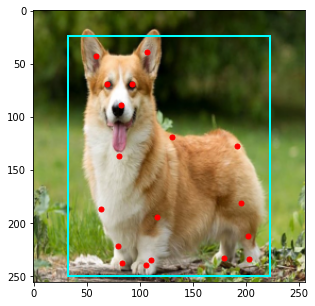

tensor(0.3109)
tensor(1)


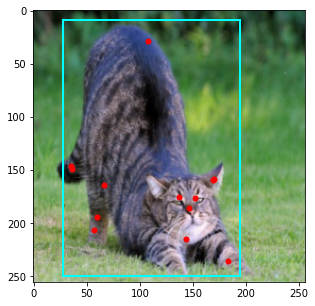

tensor(0.4691)
tensor(1)


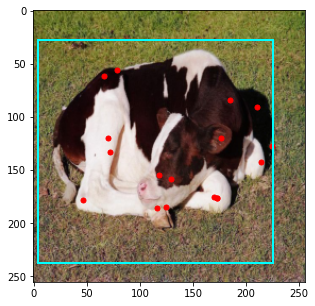

tensor(0.8462)
tensor(1)


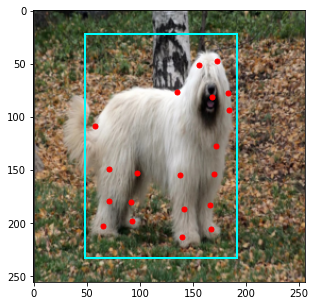

tensor(0.3030)
tensor(9)


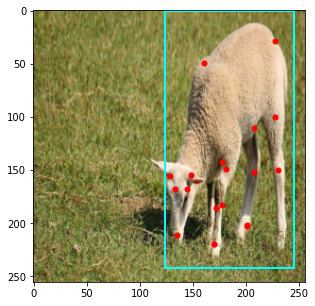

tensor(0.7654)
tensor(1)


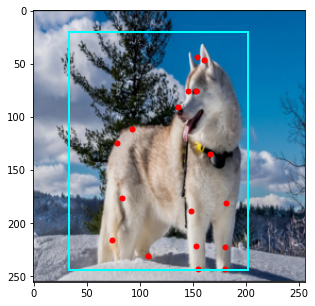

tensor(0.4885)
tensor(1)


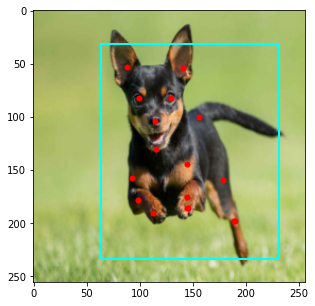

tensor(0.5462)
tensor(1)


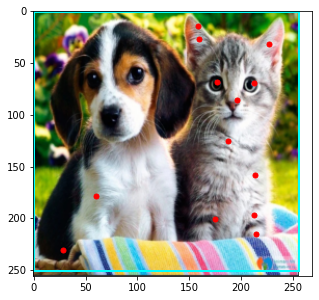

tensor(0.7101)
tensor(1)


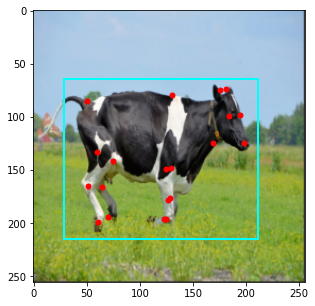

tensor(0.5001)
tensor(1)


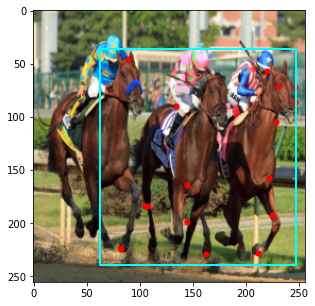

tensor(0.4489)
tensor(1)


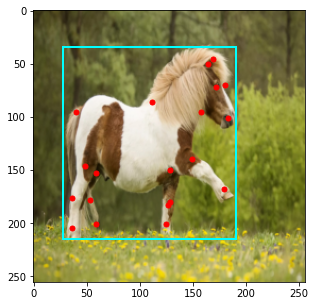

tensor(0.1377)
tensor(5)


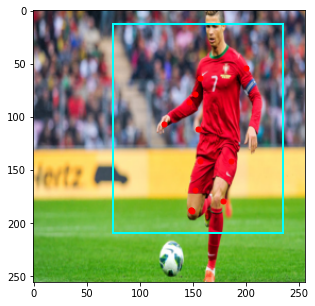

tensor(0.4151)
tensor(1)


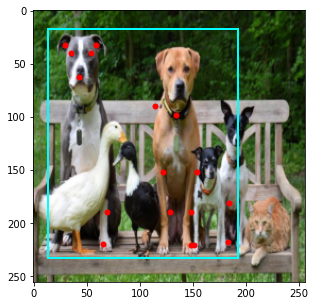

tensor(0.2359)
tensor(1)


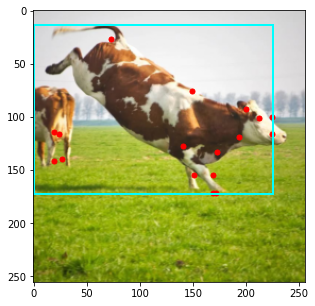

tensor(0.4117)
tensor(1)


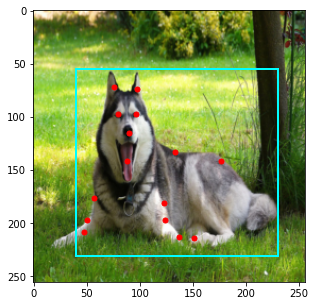

tensor(0.6324)
tensor(1)


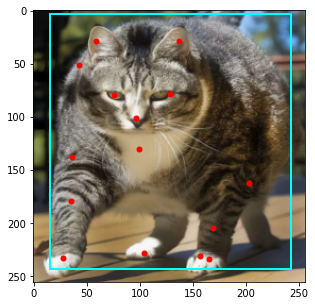

tensor(0.3503)
tensor(3)


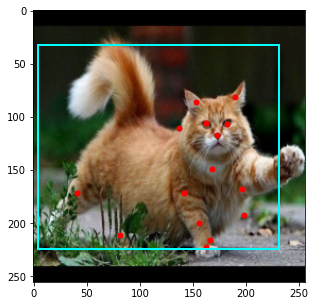

tensor(0.4168)
tensor(1)


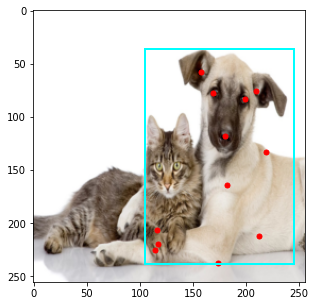

tensor(0.6373)
tensor(1)


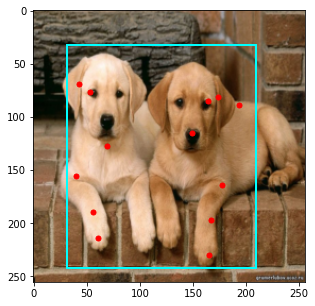

tensor(0.6258)
tensor(1)


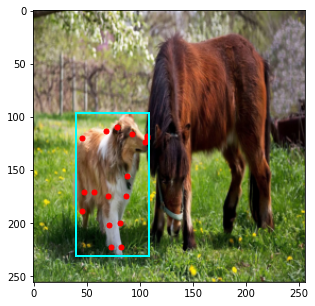

tensor(0.4181)
tensor(1)


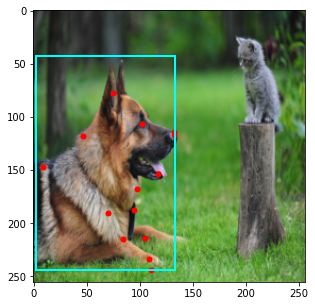

tensor(0.4855)
tensor(1)


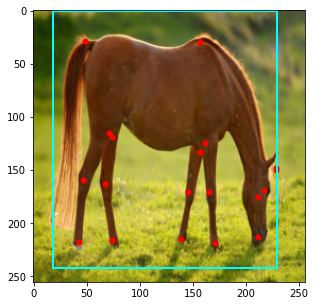

tensor(0.6509)
tensor(1)


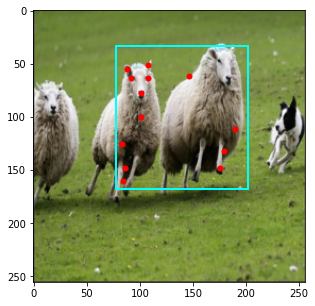

tensor(0.5956)
tensor(1)


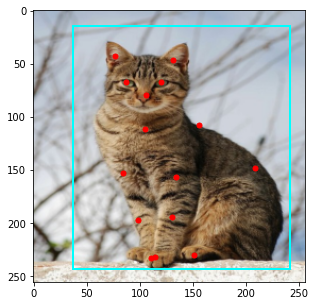

In [ ]:
for data in test_dataloader:
    inputs = data.to(device, non_blocking=True)

    with torch.no_grad():
        outputs = model(inputs)

    inputs = inputs.cpu()

    for image_idx in range(len(inputs)):
        output = outputs[image_idx]
        input = inputs[image_idx]

        draw_keypoints(output, input)

In [ ]:
torch.save(model.state_dict(), '/content/keypointrcnn_mobilenetv3small_1.pth')